In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from statsmodels import api as sm
from re import match
from datetime import datetime as dt

sns.set()
sns.set(rc={'figure.figsize':(30,8)})
SNS_CMAP = sns.light_palette("seagreen", as_cmap=True)
SNS_COLOR = sns.color_palette('muted')

# Preparation: Evaluator

In [234]:
class Evaluator():
  from datetime import datetime as dt
  from scipy.stats import t

  ff3_reader = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='1900-01-01',end=str(dt.today()))
  ff3 = ff3_reader.read()[0]/100
  ff3_reader.close()

  mom_reader = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily',start='1900-01-01',end=str(dt.today()))
  mom = mom_reader.read()[0]/100
  mom_reader.close()

  fourFactor = pd.concat([ff3,mom],axis=1)
  def __init__(self,returns):
    self.set_returns(returns)
    self.set_fourFactor()
  def set_fourFactor(self):
    self.fourFactor['Strategy-RF'] = self.returns - self.fourFactor['RF']
    self.fourFactor.dropna(inplace=True)
  def set_returns(self,returns):
    self.returns = returns.copy()
  def reset_summary(self):
    self.summary = pd.DataFrame()
  def get_summary(self):
    self.reset_summary()
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    summary = pd.DataFrame()
    summary.loc['Cum Return',['Value','Sample size']] = self.get_cumRet()
    summary.loc['Mean',['Value','Sample size']] = self.get_mean()
    summary.loc['Vol',['Value','Sample size']] = self.get_vol()
    summary.loc['SR',['Value','Sample size','P-value']] = self.get_sharpeRatio()
    summary.loc['CAPM Alpha',['Value','Sample size','P-value']] = self.get_CAPMAlpha()
    summary.loc['Carhart Alpha',['Value','Sample size','P-value']] = self.get_CarhartAlpha()
    summary.loc['Beta',['Value','Sample size','P-value']] = self.get_beta()
    summary.loc['Skew',['Value','Sample size']] = self.get_skew()
    summary.loc['Skew (M)',['Value','Sample size']] = self.get_monthlySkew()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Avg Drawdown',['Value','Sample size']] = self.get_avgDrawdown()
    summary.loc['Max Drawdown',['Value','Sample size']] = self.get_maxDrawdown()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Downside Risk',['Value','Sample size']] = self.get_downsideRisk()
    summary.loc['VaR 95%',['Value','Sample size']] = self.get_VaR(0.95)
    summary.loc['Exp Shortfall 95%',['Value','Sample size']] = self.get_expectedShortfall(0.95)
    summary.loc['VaR 99%',['Value','Sample size']] = self.get_VaR(0.99)
    summary.loc['Exp Shortfall 99%',['Value','Sample size']] = self.get_expectedShortfall(0.99)
    self.summary = summary
    return self.summary
  def get_cumsum(self):
    cumsum = self.returns.cumsum()
    return cumsum
  def get_cumprod(self):
    cumprod = (1+self.returns).cumprod()
    return cumprod
  def get_cumRet(self):
    cumprod = self.get_cumprod()[-1]
    cumRet = cumprod-1
    sampleSize = cumprod.size
    return cumRet,sampleSize
  def get_CAPMAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_beta(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    beta = result.params[1]
    p = result.pvalues[1]
    return beta,sampleSize,p
  def get_CarhartAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CAPMSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_CarhartSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_factorCorr(self):
    return self.fourFactor.corr()
  def get_mean(self):
    mean = self.returns.mean()*252
    sampleSize = self.returns.size
    return mean,sampleSize
  def get_vol(self):
    vol = self.returns.std()*np.sqrt(252)
    sampleSize = self.returns.size
    return vol,sampleSize
  def get_sharpeRatio(self):
    sharpeRatio = self.fourFactor['Strategy-RF'].mean()/self.fourFactor['Strategy-RF'].std()*np.sqrt(252)
    sampleSize = self.returns.size

    t_stat = sharpeRatio * np.sqrt(sampleSize)
    # p-value for 2-sided test
    p_2sided = 2*(1 - Evaluator.t.cdf(abs(t_stat), sampleSize))

    return sharpeRatio,sampleSize,p_2sided
  def get_monthlyReturns(self):
    monthlyReturns = (1+self.returns).resample('M').prod()-1
    return monthlyReturns
  def get_monthlySkew(self):
    monthlyReturns = self.get_monthlyReturns()
    monthlySkew = monthlyReturns.skew()
    sampleSize = monthlyReturns.size
    return monthlySkew,sampleSize
  def get_skew(self):
    skew = self.returns.skew()
    sampleSize = self.returns.size
    return skew,sampleSize
  def get_kurt(self):
    kurt = self.returns.kurt()
    sampleSize = self.returns.size
    return kurt,sampleSize
  def get_downsideRisk(self,requiredReturn=0):
    downside = requiredReturn-self.returns
    downside[downside>0] = 0
    downsideRisk = np.sqrt((downside**2).mean())*np.sqrt(252)
    sampleSize = downside[downside<0].size
    return downsideRisk,sampleSize
  def get_VaR(self,confidence=0.99):
    VaR = self.returns.quantile(q=(1-confidence))
    sampleSize = self.returns.size
    return VaR,sampleSize
  def get_expectedShortfall(self,confidence=0.99):
    VaR = self.get_VaR(confidence)[0]
    shortfall = self.returns[self.returns<VaR]
    expectedShortfall = shortfall.mean()
    sampleSize = shortfall.size
    return expectedShortfall,sampleSize
  def get_drawdowns(self):
    cumprod = self.get_cumprod()
    drawdowns = cumprod/cumprod.expanding().max() - 1
    drawdowns = drawdowns[drawdowns<0]
    return drawdowns
  def get_maxDrawdown(self):
    maxDrawdown = self.get_drawdowns().min()
    sampleSize = 1
    return maxDrawdown,sampleSize
  def get_avgDrawdown(self):
    drawdowns = self.get_drawdowns()
    avgDrawdown = drawdowns.mean()
    sampleSize = drawdowns.size
    return avgDrawdown,sampleSize

/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/3269245964.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = ff3_reader.read()[0]/100
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/3269245964.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = mom_reader.read()[0]/100


# Preparation: data

In [55]:
symbols = ['EURUSD=X','USDJPY=X','GBPUSD=X','USDCHF=X','AUDUSD=X','USDCAD=X','NZDUSD=X']

data = dict()
for symbol in symbols:
    data[symbol] = yf.download(symbol,interval='1d')
    data[symbol].to_csv(f'data/{symbol}.csv')

/Users/benkan45d6/opt/anaconda3/envs/py10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/benkan45d6/opt/anaconda3/envs/py10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Users/benkan45d6/opt/anaconda3/envs/py10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.Timed

# Add TA indicators

In [56]:
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.volatility import BollingerBands
from ta.volume import AccDistIndexIndicator
from ta.volatility import AverageTrueRange

In [57]:
def add_ta_signals(df):
    df = df.copy()

    o,h,l,c,v = df['Open'],df['High'],df['Low'],df['Close'],df['Volume']
    
    df['Ret'] = np.log(c).diff().shift(-1)

    df['MACDD'] = MACD(c).macd_diff()
    df['MACDS'] = MACD(c).macd_signal()

    df['RSI'] = RSIIndicator(c).rsi()

    df['SO'] = StochasticOscillator(h,l,c).stoch()
    df['SOS'] = StochasticOscillator(h,l,c).stoch_signal()

    df['BBH'] = BollingerBands(c).bollinger_hband_indicator() - c
    df['BBL'] = BollingerBands(c).bollinger_lband_indicator() - c

    df['ADI'] = AccDistIndexIndicator(h,l,c,v).acc_dist_index()

    df['HLR'] = c / (h.rolling(252).max() - l.rolling(252).min()) - 1 / 2

    df['ATR'] = AverageTrueRange(h,l,c).average_true_range()

    return df.drop(columns=['Open','High','Low','Close','Adj Close','Volume'])

In [79]:
ta_data = dict()
for symbol in symbols:
    ta_data[symbol] = add_ta_signals(data[symbol]).dropna()

In [80]:
train_data = dict()
test_data = dict()
frac = round(len(ta_data[symbols[0]]) * 0.2)
frac = 252
for symbol in symbols:
    train_data[symbol] = ta_data[symbol].iloc[-frac*6:-frac]
    test_data[symbol] = ta_data[symbol].iloc[-frac:]

# KNN Model

In [81]:
concat_train_data = pd.concat(train_data.values())

In [82]:
from sklearn.neighbors import KNeighborsClassifier

knns = [KNeighborsClassifier(n_neighbors=10) for _ in range(100)]
for i,knn in enumerate(knns):
        bootstrap_train_data = concat_train_data.sample(frac=0.3,replace=True)
        knn.fit(X=bootstrap_train_data.iloc[:,1:],
                y=np.sign(bootstrap_train_data.iloc[:,0]))

In [83]:
for symbol in symbols:
    df = test_data[symbol]
    pos = pd.DataFrame()
    for i,knn in enumerate(knns):
        pos[f'{i}'] = knn.predict(df.iloc[:,1:])
    df['Pred'] = pos.mean(axis=1).to_numpy()
    df['Pos'] = (np.around(df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
    df['Pnl'] = df['Pos'] * df['Ret']

/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/136500327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred'] = pos.mean(axis=1).to_numpy()
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/136500327.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pos'] = (np.around(df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/136500327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [84]:
for symbol in symbols:
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s
    print(f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

EURUSD=X (m=16.94% s=5.31% SR = 3.19)
USDJPY=X (m=9.00% s=7.55% SR = 1.19)
GBPUSD=X (m=22.32% s=5.24% SR = 4.26)
USDCHF=X (m=9.56% s=5.34% SR = 1.79)
AUDUSD=X (m=13.23% s=7.04% SR = 1.88)
USDCAD=X (m=6.20% s=3.34% SR = 1.86)
NZDUSD=X (m=9.04% s=6.84% SR = 1.32)


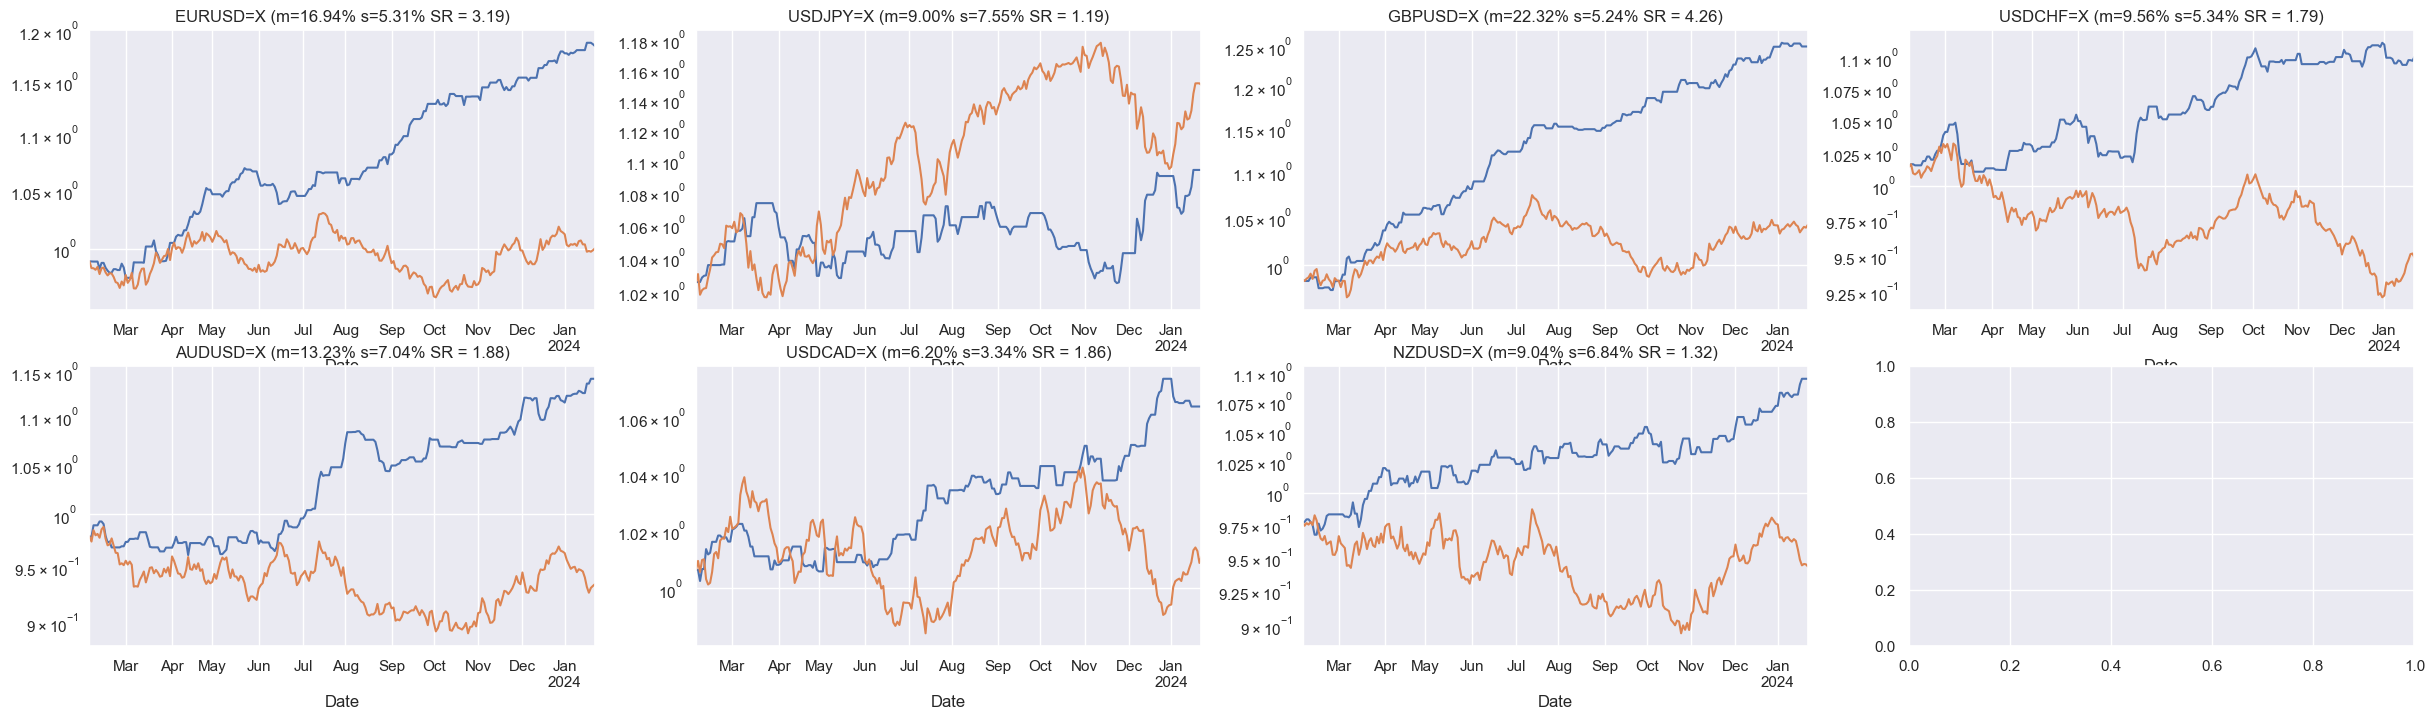

In [85]:
fig,axes = plt.subplots(2,4)
for i,symbol in enumerate(symbols):
    df = test_data[symbol]

    m = df["Pnl"].mean()*252
    s = df["Pnl"].std()*252**0.5
    SR = m/s

    r,c = i//4,i%4
    ax = axes[r,c]

    ax.set_title(f'{symbol} (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')
    ax.set_yscale('log')
    np.exp(df['Pnl'].cumsum()).plot(ax=ax)
    np.exp(df['Ret'].cumsum()).plot(ax=ax)

    '''
    ax2 = ax.twinx()
    temp = pd.DataFrame({'Long':df['Pos'][df['Pos']>=0],
                         'Short':df['Pos'][df['Pos']<0]})
    ax2.bar(temp.index,temp['Long'],alpha=0.7,color='green')
    ax2.bar(temp.index,temp['Short'],alpha=0.7,color='red')
    '''


In [86]:
test_return = pd.DataFrame()
for symbol in symbols:
    df = test_data[symbol]
    test_return[symbol] = df['Pnl']

In [87]:
test_return_weight = 1/test_return.rolling(30).std()
test_return_weight = test_return_weight.div(test_return_weight.sum(axis=1),axis=0)

Text(0.5, 1.0, 'Portfolio of 7 major pairs (m=12.33% s=2.50% SR = 4.94)')

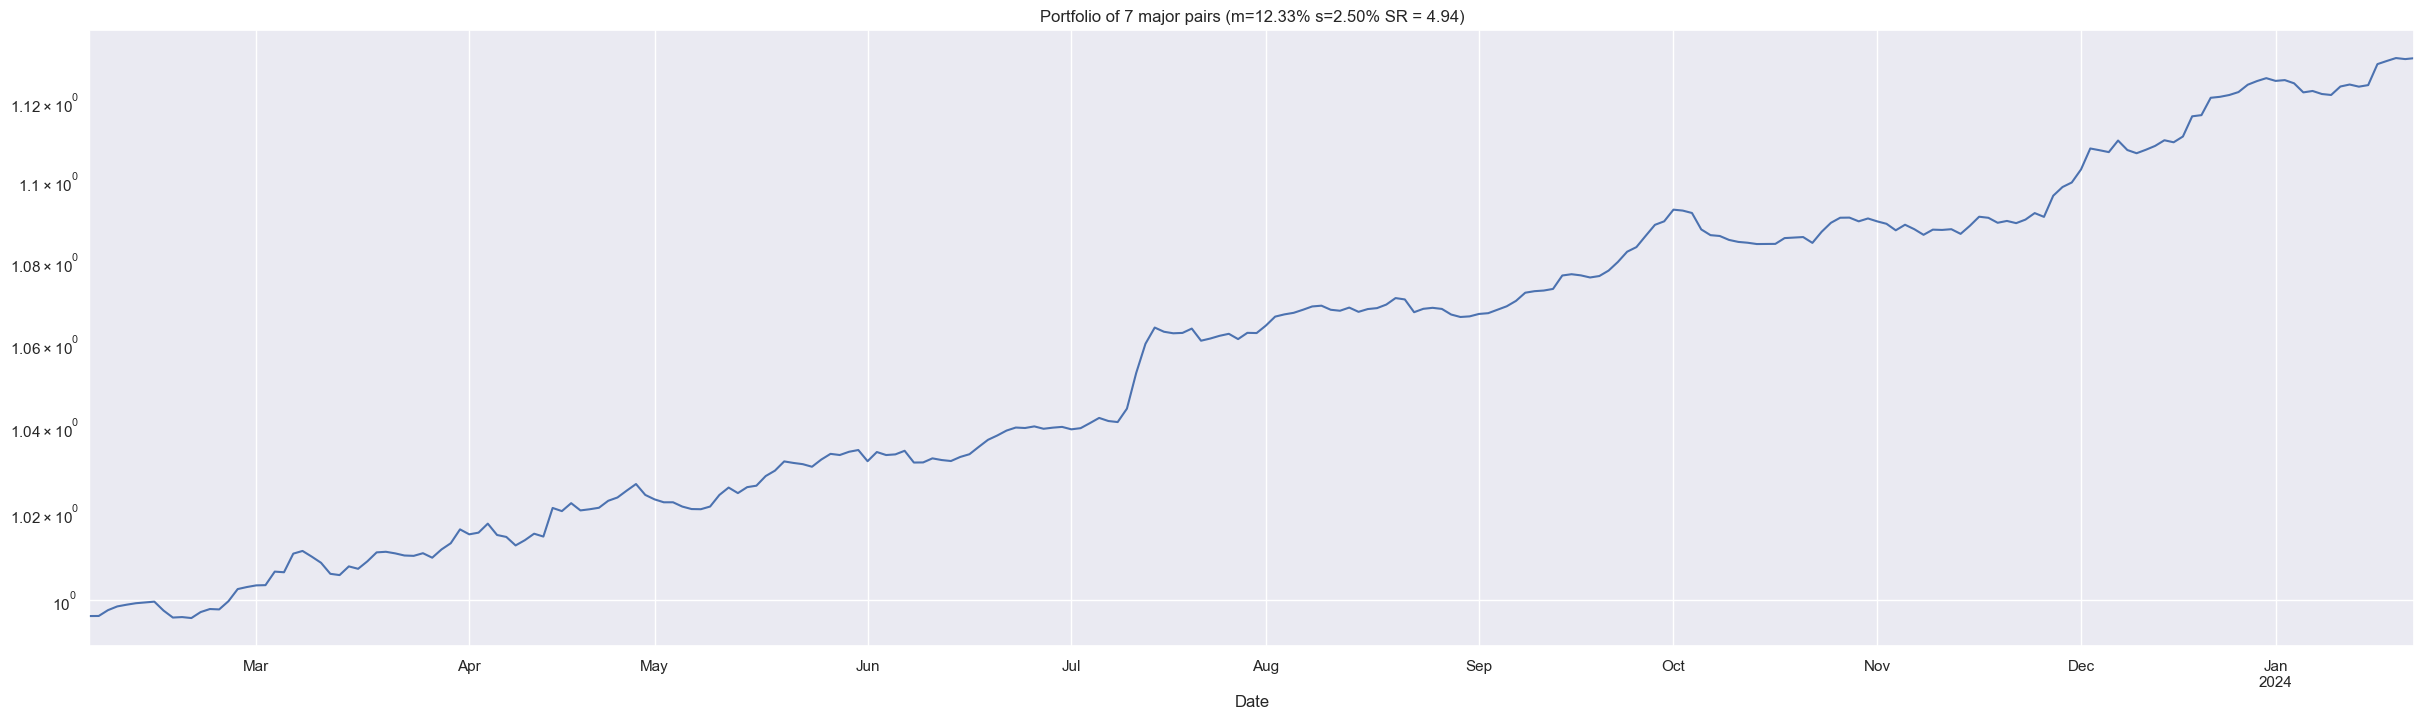

In [88]:
#port_return = (test_return * test_return_weight.shift(1)).sum(axis=1)
port_return = test_return.mean(axis=1)

m = port_return.mean()*252
s = port_return.std()*252**0.5
SR = m/s

ax = np.exp(port_return.cumsum()).plot()
ax.set_yscale('log')
ax.set_title(f'Portfolio of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

In [89]:
Evaluator(port_return).get_summary()

/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/3269245964.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumprod = self.get_cumprod()[-1]
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/3269245964.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = result.params[0]*252
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/3269245964.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

,Value,Sample size,P-value
Cum Return,0.1308,1.0000,NaN
Mean,0.1233,252.0000,NaN
Vol,0.0250,252.0000,NaN
SR,2.5800,252.0000,0.0000
CAPM Alpha,0.0643,208.0000,0.0204
Carhart Alpha,0.0617,208.0000,0.0276
Beta,0.0003,208.0000,0.9791
Skew,1.0188,252.0000,NaN
Skew (M),0.7425,12.0000,NaN
Kurt,3.6340,252.0000,NaN


# Walk forward test

In [120]:
dates = pd.DataFrame()
dates['test_end'] = ta_data['USDJPY=X'].index[::-252]
dates['test_start'] = dates['test_end'].shift(-1)
dates['train_end'] = dates['test_start']
dates['train_start'] = dates['train_end'].shift(-5)
dates = dates.loc[dates.index[::-1]].iloc[6:].reset_index(drop=True)

In [205]:
train_data_list = list()
test_data_list = list()
for i in range(len(dates)):
    train_data = dict()
    test_data = dict()

    print(f'{i}-th dataset:')

    for symbol in symbols:
        train_start, train_end = dates.loc[i,'train_start'], dates.loc[i,'train_end']
        test_start, test_end = dates.loc[i,'test_start'], dates.loc[i,'test_end']

        train = ta_data[symbol].loc[:train_end]
        test = ta_data[symbol].loc[test_start:test_end].iloc[1:]

        train_data[symbol] = train
        test_data[symbol] = test
        #print(f'{symbol} {i}-th dataset: trained {train_start.date()} to {train_end.date()}, tested {test_start.date()} to {test_end.date()}')

        

        try:
            train_start_date = train.index[0].date()
            train_end_date = train.index[-1].date()
        except:
            train_start_date = '{NO DATA}'
            train_end_date = '{NO DATA}'

        try:
            test_start_date = test.index[0].date()
            test_end_date = test.index[-1].date()
        except:
            test_start_date = '{NO DATA}'
            test_end_date = '{NO DATA}'

        print(f'    {symbol} [{len(train)},{len(test)}]: trained {train_start_date} to {train_end_date}, tested {test_start_date} to {test_end_date}')

    train_data_list.append(train_data)
    test_data_list.append(test_data)

    print()

0-th dataset:
    EURUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USDJPY=X [1266,252]: trained 1997-11-05 to 2002-09-11, tested 2002-09-12 to 2003-08-29
    GBPUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USDCHF=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    AUDUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USDCAD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    NZDUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}

1-th dataset:
    EURUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USDJPY=X [1518,252]: trained 1997-11-05 to 2003-08-29, tested 2003-09-01 to 2004-08-17
    GBPUSD=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    USDCHF=X [0,0]: trained {NO DATA} to {NO DATA}, tested {NO DATA} to {NO DATA}
    AUDUSD=X [0,0]: trained {NO DATA} to {NO DATA},

In [206]:
knns_list = list()
for i,train_data in enumerate(train_data_list):
    print(f'Training {i}-th dataset')
    #print(train_data.keys())
    concat_train_data = pd.concat(train_data.values())
    knns = [KNeighborsClassifier(n_neighbors=10) for _ in range(100)]
    for i,knn in enumerate(knns):
        bootstrap_train_data = concat_train_data.sample(frac=0.3,replace=True)
        knn.fit(X=bootstrap_train_data.iloc[:,1:],
            y=np.sign(bootstrap_train_data.iloc[:,0]))
    knns_list.append(knns)

Training 0-th dataset
Training 1-th dataset
Training 2-th dataset
Training 3-th dataset
Training 4-th dataset
Training 5-th dataset
Training 6-th dataset
Training 7-th dataset
Training 8-th dataset
Training 9-th dataset
Training 10-th dataset
Training 11-th dataset
Training 12-th dataset
Training 13-th dataset
Training 14-th dataset
Training 15-th dataset
Training 16-th dataset
Training 17-th dataset
Training 18-th dataset
Training 19-th dataset
Training 20-th dataset
Training 21-th dataset


In [207]:
for i,(test_data,knns_list) in enumerate(zip(test_data_list,knns_list)):
    print(f'Trading {i}-th dataset')
    for symbol in symbols:
        df = test_data[symbol]
        pos = pd.DataFrame()
        if len(df) > 0:
            for i,knn in enumerate(knns):
                pos[f'{i}'] = knn.predict(df.iloc[:,1:])
            df['Pred'] = pos.mean(axis=1).to_numpy()
            #df['Pos'] = np.around((df['Pred'].expanding().rank(pct=True)*2-1)*5)/5
            df['Pos'] = np.around(df['Pred']*5)/5
            df['Pnl'] = df['Pos'] * df['Ret']

Trading 0-th dataset
Trading 1-th dataset
Trading 2-th dataset
Trading 3-th dataset
Trading 4-th dataset
Trading 5-th dataset
Trading 6-th dataset
Trading 7-th dataset
Trading 8-th dataset
Trading 9-th dataset
Trading 10-th dataset
Trading 11-th dataset
Trading 12-th dataset
Trading 13-th dataset
Trading 14-th dataset
Trading 15-th dataset
Trading 16-th dataset
Trading 17-th dataset
Trading 18-th dataset
Trading 19-th dataset
Trading 20-th dataset
Trading 21-th dataset


In [208]:
test_return_list = list()
for i,test_data in enumerate(test_data_list):
    test_return = pd.DataFrame()
    for symbol in symbols:
        if len(test_data[symbol]) > 0:
            test_return[symbol] = test_data[symbol]['Pnl']
    test_return['Port'] = test_return.mean(axis=1)
    test_return_list.append(test_return)

In [210]:
test_pos_list = list()
test_pred_list = list()
for i,test_data in enumerate(test_data_list):
    test_pos = pd.DataFrame()
    test_pred = pd.DataFrame()
    for symbol in symbols:
        if len(test_data[symbol]) > 0:
            test_pos[symbol] = test_data[symbol]['Pos']
            test_pred[symbol] = (np.sign(test_data[symbol]['Pred']) == np.sign(test_data[symbol]['Ret']))
    test_pos_list.append(test_pos)
    test_pred_list.append(test_pred)

Text(0.5, 1.0, 'Walk-forward portfolio return of 7 major pairs (m=14.32% s=2.64% SR = 5.43)')

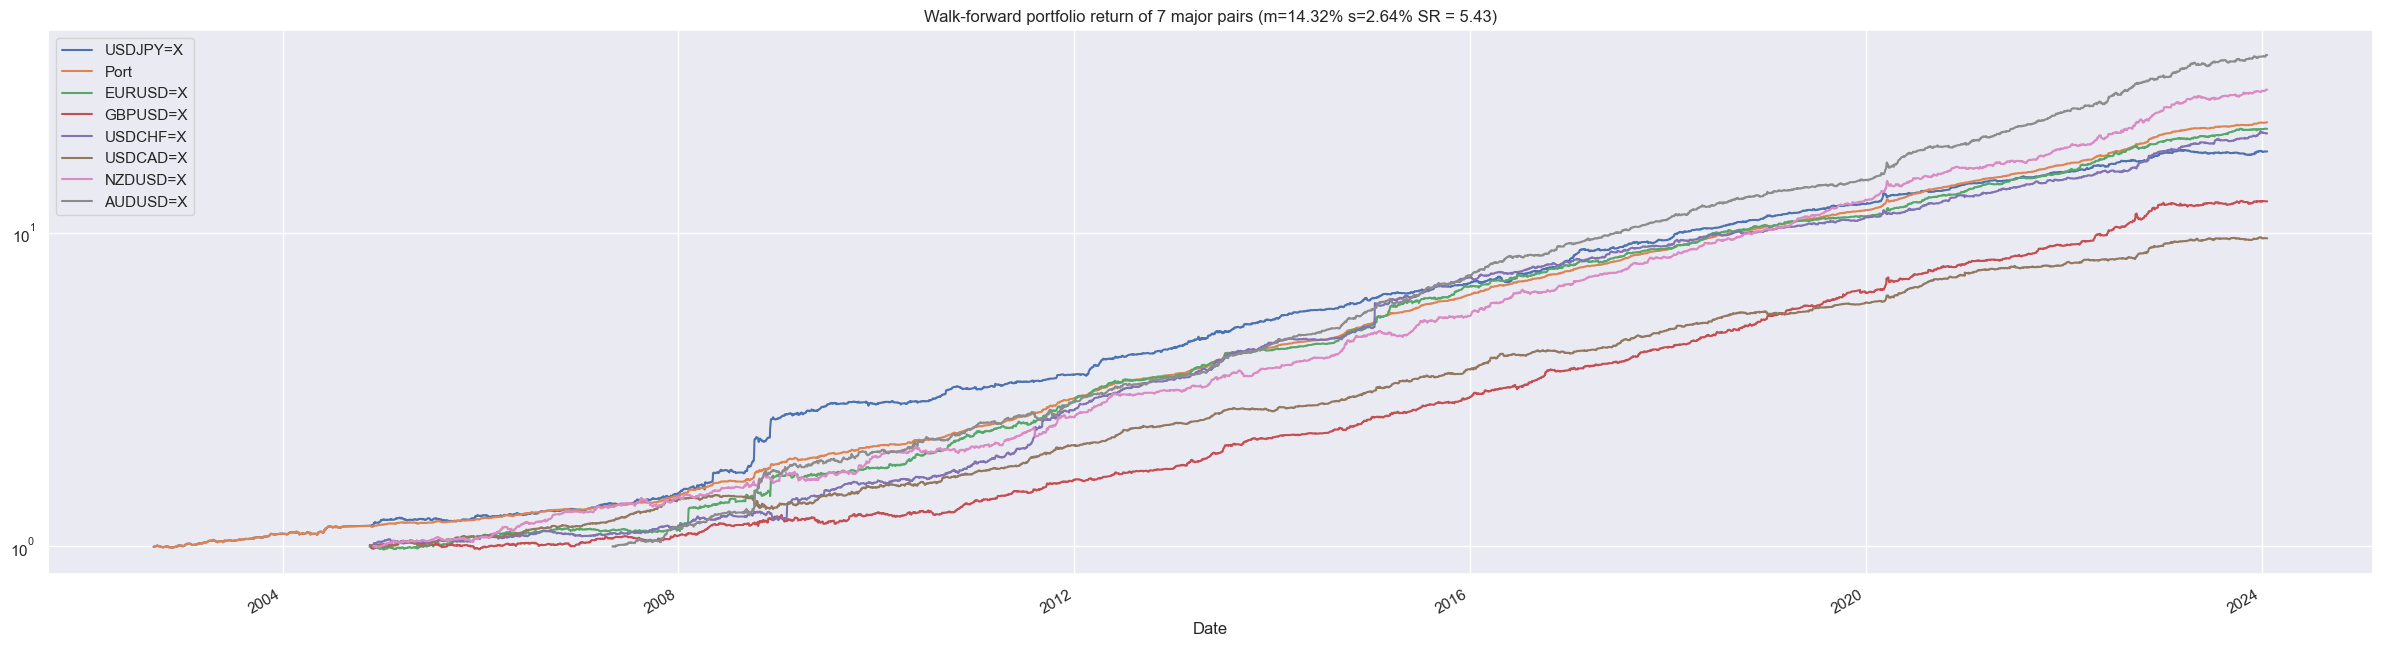

In [235]:
concat_test_return = pd.concat(test_return_list,axis=0)

ax = np.exp(concat_test_return.cumsum()).plot()
ax.set_yscale('log')

m = concat_test_return['Port'].mean()*252
s = concat_test_return['Port'].std()*252**0.5
SR = m/s

ax.set_title(f'Walk-forward portfolio return of 7 major pairs (m={m*100:.2f}% s={s*100:.2f}% SR = {SR:.2f})')

In [236]:
m = concat_test_return.mean()*252
s = concat_test_return.std()*np.sqrt(252)
SR = m/s
pd.DataFrame({'Mean':m,
              'Vol':s,
              'SR':SR})

,Mean,Vol,SR
USDJPY=X,0.1334,0.0538,2.4801
Port,0.1432,0.0264,5.4305
EURUSD=X,0.1553,0.0607,2.5594
GBPUSD=X,0.1285,0.0487,2.6385
USDCHF=X,0.1538,0.0649,2.3708
USDCAD=X,0.1146,0.0430,2.6640
NZDUSD=X,0.1706,0.0600,2.8452
AUDUSD=X,0.2097,0.0612,3.4274


In [237]:
concat_test_return['Port']

Date
2002-09-12   -0.0026
2002-09-13    0.0000
2002-09-16    0.0011
2002-09-17    0.0000
2002-09-18    0.0000
               ...  
2024-01-16    0.0011
2024-01-17    0.0014
2024-01-18    0.0006
2024-01-19   -0.0003
2024-01-22   -0.0001
Name: Port, Length: 5479, dtype: float64

In [238]:
Evaluator(concat_test_return['Port']).get_summary()

/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/3269245964.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumprod = self.get_cumprod()[-1]
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/3269245964.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = result.params[0]*252
/var/folders/vh/jb52psn93fb96vlsr5_kn4m80000gn/T/ipykernel_13110/3269245964.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

,Value,Sample size,P-value
Cum Return,21.3238,1.0000,NaN
Mean,0.1432,5479.0000,NaN
Vol,0.0264,5479.0000,NaN
SR,5.0012,5479.0000,0.0000
CAPM Alpha,0.1346,5249.0000,0.0000
Carhart Alpha,0.1347,5249.0000,0.0000
Beta,-0.0115,5249.0000,0.0000
Skew,2.4778,5479.0000,NaN
Skew (M),1.3225,257.0000,NaN
Kurt,35.1344,5479.0000,NaN


In [192]:
ta_data

{'EURUSD=X':                Ret   MACDD  MACDS     RSI      SO     SOS     BBH     BBL  \
 Date                                                                        
 2004-11-17 -0.0068  0.0002 0.0137 72.1393 97.1424 89.5390 -1.3038 -1.3038   
 2004-11-18  0.0069 -0.0004 0.0136 63.3497 69.5543 85.2316 -1.2949 -1.2949   
 2004-11-19  0.0001 -0.0002 0.0135 67.6440 91.6658 86.1208 -1.3039 -1.3039   
 2004-11-22  0.0044 -0.0003 0.0134 67.6902 91.9163 84.3788 -1.3040 -1.3040   
 2004-11-23  0.0062 -0.0000 0.0134 70.2490 98.1121 93.8981 -1.3097 -1.3097   
 ...            ...     ...    ...     ...     ...     ...     ...     ...   
 2024-01-16 -0.0061 -0.0012 0.0027 49.9336 28.8667 31.1489 -1.0946 -1.0946   
 2024-01-17  0.0006 -0.0016 0.0023 42.6270 13.8506 22.6950 -1.0879 -1.0879   
 2024-01-18 -0.0006 -0.0017 0.0019 43.5555 19.4126 20.7100 -1.0886 -1.0886   
 2024-01-19  0.0012 -0.0018 0.0014 42.8466 16.8166 16.6933 -1.0879 -1.0879   
 2024-01-22  0.0015 -0.0016 0.0010 44.7668 31.0618 2

In [188]:
concat_test_return['Port']

Date
2002-09-12    0.0000
2002-09-13    0.0011
2002-09-16    0.0014
2002-09-17   -0.0021
2002-09-18    0.0000
               ...  
2024-01-16    0.0032
2024-01-17    0.0006
2024-01-18   -0.0001
2024-01-19   -0.0004
2024-01-22    0.0001
Name: Port, Length: 5479, dtype: float64